In [1]:
import plaidml.keras
plaidml.keras.install_backend()

import os
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"
cwd = os.getcwd()

from keras import backend as K

In [2]:
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
from keras.models import Sequential
from keras.layers import Cropping2D

In [3]:
import glob
import cv2 as cv

path = glob.glob("C:\\Users\\alikr\\Projects\\JupyterNotebook\\Deep Learning\\Çalışmalar\\maskedAndUnmasked\\veriler\\*\\*")

In [4]:
categories = []
imgnames = []
for i in range(len(path)):
    imgnames.append(path[i].split("\\")[-1])
    a = ((path[i].split("\\")[-1]).rstrip(".jpg")).split("_")[1:]
    if len(a)==1:
        categories.append("Correct")
    else:
        categories.append("False")

In [5]:
df = pd.DataFrame({
'filename': path,
'category': categories,
'imgname': imgnames
})
df_ = df.sample(frac=1).reset_index(drop=True)
df_

,filename,category,imgname
0,C:\Users\alikr\Projects\JupyterNotebook\Deep L...,False,12959_Mask_Mouth_Chin.jpg
1,C:\Users\alikr\Projects\JupyterNotebook\Deep L...,Correct,63893_Mask.jpg
2,C:\Users\alikr\Projects\JupyterNotebook\Deep L...,False,39398_Mask_Mouth_Chin.jpg
3,C:\Users\alikr\Projects\JupyterNotebook\Deep L...,False,23682_Mask_Mouth_Chin.jpg
4,C:\Users\alikr\Projects\JupyterNotebook\Deep L...,Correct,33048_Mask.jpg
...,...,...,...
133777,C:\Users\alikr\Projects\JupyterNotebook\Deep L...,Correct,18257_Mask.jpg
133778,C:\Users\alikr\Projects\JupyterNotebook\Deep L...,False,30619_Mask_Mouth_Chin.jpg
133779,C:\Users\alikr\Projects\JupyterNotebook\Deep L...,Correct,16164_Mask.jpg
133780,C:\Users\alikr\Projects\JupyterNotebook\Deep L...,False,19588_Mask_Mouth_Chin.jpg


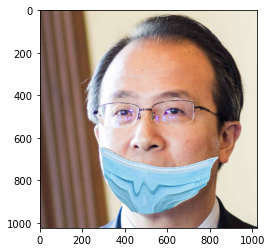

In [6]:
sample = random.choice(path)
image = load_img(sample)
plt.imshow(image)

In [7]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(16, 16, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size= (3, 3)))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(32, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation = 'softmax')) 

model.compile(loss = 'categorical_crossentropy', optimizer = 'rmsprop', metrics = ['accuracy'])

model.summary()

INFO:plaidml:Opening device "opencl_amd_gfx1012.0"


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 14, 14, 16)        448       
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 16)        64        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 16)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 4, 4, 16)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                8224      
_________________________________________________________________
batch_normalization_2 (Batch (None, 32)                128       
__________

In [8]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

earlystop = EarlyStopping(patience = 3)

learning_rate_reduction = ReduceLROnPlateau(monitor = "val_acc",
                                           patience = 2,
                                           verbose = 1,
                                           factor = 0.5,
                                           min_lr = 0.0001)

In [9]:
callbacks = [earlystop, learning_rate_reduction]

In [10]:
train_df, validate_df = train_test_split(df_, test_size = 0.05, random_state = 42)

In [11]:
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop = True)

<AxesSubplot:>

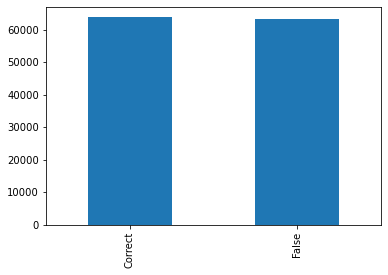

In [12]:
train_df["category"].value_counts().plot.bar()

<AxesSubplot:>

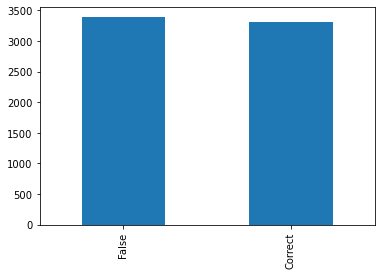

In [13]:
validate_df["category"].value_counts().plot.bar()

In [14]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size = 150

In [15]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    shear_range = 0.1,
    zoom_range = 0.2,
    horizontal_flip = True
)

In [16]:
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col = 'filename',
    y_col = 'category',
    class_mode = "categorical",
    target_size = (16, 16),
    batch_size = batch_size
)

Found 127092 validated image filenames belonging to 2 classes.


In [17]:
validation_datagen = ImageDataGenerator(rescale = 1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df,
    x_col = "filename",
    y_col = "category",
    target_size = (16, 16),
    class_mode = "categorical",
    batch_size = batch_size
)

Found 6690 validated image filenames belonging to 2 classes.


In [18]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df,
    x_col = "filename",
    y_col = "category",
    target_size = (16, 16),
    class_mode = "categorical"
)

Found 1 validated image filenames belonging to 1 classes.


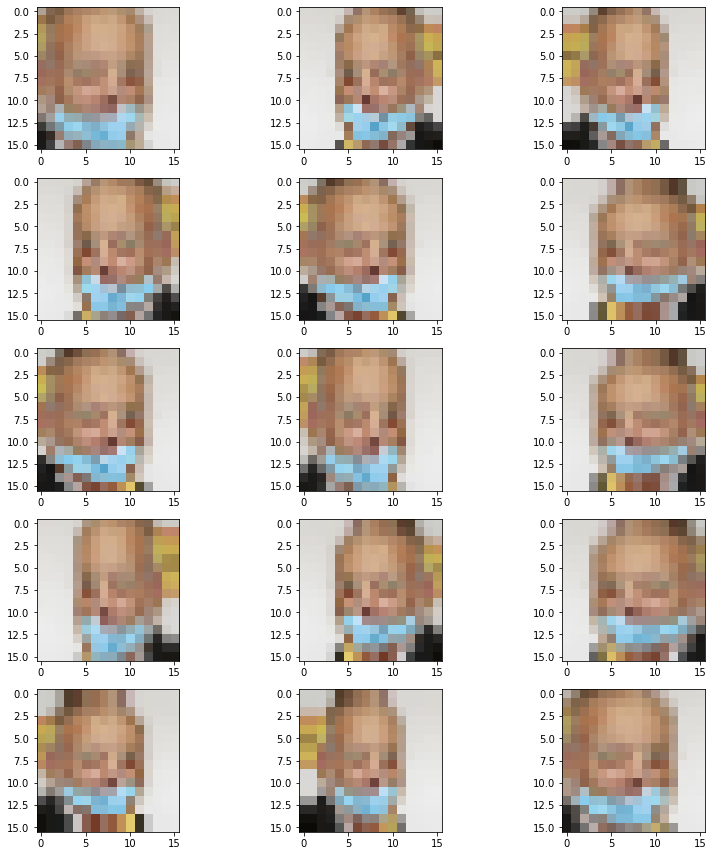

In [19]:
plt.figure(figsize = (12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [20]:
epochs = 10
history = model.fit_generator(
    train_generator,
    epochs = epochs,
    validation_data = validation_generator,
    validation_steps = total_validate//batch_size,
    steps_per_epoch = total_train//batch_size,
    callbacks = callbacks
)

Epoch 1/10
847/847 [==============================] - 2385s 3s/step - loss: 0.5037 - acc: 0.7713 - val_loss: 0.6610 - val_acc: 0.6897
Epoch 2/10
847/847 [==============================] - 2368s 3s/step - loss: 0.4230 - acc: 0.8140 - val_loss: 0.3901 - val_acc: 0.8255
Epoch 3/10
847/847 [==============================] - 2360s 3s/step - loss: 0.4060 - acc: 0.8241 - val_loss: 0.3764 - val_acc: 0.8338
Epoch 4/10
847/847 [==============================] - 2547s 3s/step - loss: 0.4034 - acc: 0.8273 - val_loss: 0.3664 - val_acc: 0.8398
Epoch 5/10
847/847 [==============================] - 2846s 3s/step - loss: 0.4009 - acc: 0.8276 - val_loss: 0.3603 - val_acc: 0.8431
Epoch 6/10
847/847 [==============================] - 2987s 4s/step - loss: 0.3999 - acc: 0.8277 - val_loss: 0.3719 - val_acc: 0.8359
Epoch 7/10
492/847 [================>.............] - ETA: 18:38 - loss: 0.3946 - acc: 0.8303

KeyboardInterrupt: 

In [21]:
loss, accuracy = model.evaluate_generator(validation_generator, total_validate//batch_size, workers = 12)
print("Test: accuracy = %f ; loss = %f" % (accuracy, loss))

Test: accuracy = 0.843939 ; loss = 0.357318


In [22]:
def plot_model_history(model_history, acc ='acc', val_acc = 'val_acc'):
    fig, axs = plt.subplots(1, 2, figsize= (15,5))
    axs[0].plot(range(1, len(model_history.history[acc])+1), model_history.history[acc])
    axs[0].plot(range(1, len(model_history.history[val_acc])+1), model_history.history[val_acc])
    axs[0].set_title("Model Accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].set_xlabel("Epoch")
    axs[0].set_xticks(np.arange(1, len(model_history.history[acc])+1), len(model_history.history[acc])/10)
    axs[0].legend(["train", "val"], loc = "best")
    axs[1].plot(range(1, len(model_history.history["loss"])+1), model_history.history["loss"])
    axs[1].plot(range(1, len(model_history.history["val_loss"])+1), model_history.history["val_loss"])
    axs[1].set_title("Model Loss")
    axs[1].set_ylabel("Loss")
    axs[1].set_xlabel("Epoch")
    axs[1].set_xticks(np.arange(1, len(model_history.history["loss"])+1), len(model_history.history["loss"])/10)
    axs[1].legend(["train", "val"], loc = "best")
    plt.show()

plot_model_history(history)

NameError: name 'history' is not defined